# My Tokenizer

## Initial Setup

### imports

In [1]:
import cProfile
import os
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset

# tqdm
try:
    if 'ZMQInteractiveShell' == get_ipython().__class__.__name__:
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm
except NameError:
    from tqdm import tqdm

# torch
if torch.cuda.is_available():
    torch.set_default_device('cuda')
#elif torch.backends.mps.is_available():
#    torch.set_default_device('mps')
else:
    torch.set_default_device('cpu')

### editable config

In [8]:
MAX_VOCAB_SIZE: int = 10_000  # maximum size of vocab
MAX_TOKEN_LEN: int = 40  # maximum length of token
RANDOM_SEED = 42
MAX_DATASET_EXAMPLES = 100 # 36_718

MAX_ENTROPY = float(np.log2(MAX_VOCAB_SIZE))

#### static config

In [9]:
ASCII_PUNCTUATION = [bytes([i]) for i in range(32,48)] + [bytes([i]) for i in range(58,65)] + [bytes([i]) for i in range(91,97)] + [bytes([i]) for i in range(123,127)]
ASCII_DIGITS = [bytes([i]) for i in range(48,58)]
ASCII_LOWERCASE = [bytes([i]) for i in range(97,123)]
ASCII_UPPERCASE = [bytes([i]) for i in range(65,91)]
ASCII_CONTROL = [bytes([i]) for i in range(0,32)]
ASCII_OTHER = [bytes([i]) for i in range(127,256)]

## Helper functions

In [16]:
def normalize(c, dim=None):
    """Converts a Counter or dict to a probability distribution"""
    if isinstance(c, (dict, Counter)):
        total = sum(c.values())
        p = {k: v / total for k, v in c.items()}
    else:
        if not isinstance(c, torch.Tensor):
            c = torch.tensor([v for v in c], dtype=torch.float, requires_grad=False)
        p = c / c.sum(dim=dim, keepdim=True)
    return p
    
def entropy(c, dim=None, keepdim=False):
    """Computes the entropy of a Counter or dict"""
    if isinstance(c, (dict, Counter)):
        c = list(c.values())
    p = normalize(c, dim=dim)
    h = -torch.sum(p * torch.log2(p).nan_to_num(), dim=dim, keepdim=keepdim)
    if h.squeeze().shape == torch.Size([]):
        h = h.item()
    return h

def find_best_merge(vocab, merges): #a_token, b_tokens, b_freqs, merge_tokens, merge_freqs):
    if len(merges) == 1:
        return merges[0]

    # We're going to build a tensor of all the resulting frequencies from merges. 
    # The tensor will have shape (len(merges), len(freqs)+1)
    # each row will correspond to one possible merge and each column will correspond to the frequency of one token
    vocab_tokens, vocab_freqs = list(zip(*vocab.items()))
    vocab_freqs = torch.tensor(vocab_freqs, requires_grad=False)
    merge_freqs = torch.tensor([x['mf'] for x in merges], requires_grad=False).unsqueeze(1)
    freqs_t = vocab_freqs.unsqueeze(0) * torch.ones(len(merge_freqs), 1)
    assert freqs_t.shape == (len(merges), len(vocab_freqs)), f"ERROR: {freqs_t.shape=} != {len(merges)=} x {len(vocab_freqs)=}"

    # we need to find the indices of left and right halves of the merge token so we can subtract the merge frequencies from them
    lt_idxes = torch.tensor([vocab_tokens.index(x['lt']) for x in merges], requires_grad=False)
    rt_idxes = torch.tensor([vocab_tokens.index(x['rt']) for x in merges], requires_grad=False)
    freqs_t[:, lt_idxes] -= merge_freqs
    freqs_t[:, rt_idxes] -= merge_freqs
    
    # now we concatenate the merge frequencies to the end of each row
    freqs_t = torch.cat([freqs_t, merge_freqs], dim=1)
    assert freqs_t.shape == (len(merges), len(vocab_freqs)+1), f"ERROR: {freqs_t.shape=} != {len(merges)=} x {len(vocab_freqs)+1=}"
    
    # now we calculate the resulting entropy of each row and pick the merge that maximizes entropy
    h = entropy(freqs_t, dim=-1)
    best_idx = int(torch.argmax(h))    
    merge = merges[best_idx]

    return merge

def record_progress(x_time, y_freqs, vocab):
    # This is an awful function
    t = time.time()
    y = sorted(list(vocab.values()))
    x_time.append(t)
    y_freqs.append(y)
    t0 = x_time[0]
    ymax0 = max(y_freqs[0])
    xmin = 0
    xmax = MAX_VOCAB_SIZE
    ymin = .9
    x = np.arange(len(y))
    y = np.array(y)
    ymean = y.mean()
    ystd = y.std()
    ideal_y = ymean * np.ones(len(y))
    for log in [True]: #, False]:
        #if log:
        #    ymax = ymax0
        #else:
        #    ymax = y.max()

        plt.plot(x, y, color='blue', label=f'token frequencies (h={entropy(y):.01f} bits)')
        plt.plot(x, ideal_y, color='orange', label=f'mean = {ymean:,.1f} (h={np.log2(len(y)):.1f} bits)')
        plt.plot(x, ideal_y + ystd, color='green', label=f'mean+stddev = {ymean+ystd:,.1f} (h={np.log2(len(y)):.1f} bits)')
        if ymean - ystd > 0:
            plt.plot(x, ideal_y - ystd, color='green', label=f'mean-stddev = {ymean-ystd:,.1f} (h={np.log2(len(y)):.1f} bits)')
        plt.title(f"{int(t-t0):,}s since start\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {MAX_ENTROPY:.01f} bits , {len(y)} tokens")
        plt.ylabel('num occurences')
        plt.xlabel('token id')
        if log:
            plt.yscale('log')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        # set background to white 
        plt.rcParams['axes.facecolor']='white'
        fname = f'images/progress_{len(y)}{"_log" if log else ""}.png'
        plt.legend()
        plt.savefig(fname, dpi=300)
        #print(fname)
        #plt.show()
        plt.close()


## Cache Frequencies for Potential Tokens 

In [11]:
# def make_freqs_cache(ds_name="wikitext", data_dir="wikitext-2-raw-v1", split="train")
def make_freqs_cache(ds_name="graelo/wikipedia", data_dir="20230901.en", split="train"):
    print(f"Loading dataset...", flush=True)
    t0 = time.time()
    ds = load_dataset(ds_name, data_dir, split=split)
    dl = ds.to_iterable_dataset().shuffle(seed=RANDOM_SEED, buffer_size=10_000)
    print(f"Loaded dataset in {time.time() - t0:.1f} seconds", flush=True)

    cache = dict()
    with tqdm(total=MAX_DATASET_EXAMPLES, desc="Finding byte string frequencies", unit='example') as pb:
        for i, ex in enumerate(dl):
            if i >= MAX_DATASET_EXAMPLES:
                break
            ex = bytes(ex['text'], 'utf-8')
            for L in range(1, MAX_TOKEN_LEN+1):
                recent_slices = []  
                for i in range(len(ex) - L):
                    t = ex[i:i+L]
                    if t not in recent_slices:  # don't count a token twice if it overlaps itself. ex.count() is too slow
                        cache[t] = cache.get(t, 0) + 1
                    recent_slices.append(t)
                    recent_slices = recent_slices[-L:]
                del(recent_slices)

            pb.update(1)
            pb.refresh()

    return cache

FREQS_CACHE = make_freqs_cache()

print(f"Found frequencies for {len(FREQS_CACHE):,} potential tokens. example: {next(iter(FREQS_CACHE.items()))}", flush=True)

Loading dataset...
Loaded dataset in 1.8 seconds


Finding byte string frequencies:   0%|          | 0/100 [00:00<?, ?example/s]

Found frequencies for 24,415,290 potential tokens. example: (b'O', 878)


## Build Vocabulary

### initialize vocab with all 1-byte tokens

In [59]:
all_bytes = [bytes([i]) for i in range(256)]
vocab = Counter({t: FREQS_CACHE.get(t, 0) for t in all_bytes}) # if t not in ASCII_DIGITS + ASCII_PUNCTUATION})
vocab.most_common(3)

[(b' ', 118038), (b'e', 66685), (b'a', 51336)]

In [60]:
x_time = []
y_freqs = []
ymin, ymax = 0.5, max(vocab.values())

### merge pairs of tokens to increase the vocabulary size and entropy

In [61]:
MAX_MERGES = 4 * MAX_VOCAB_SIZE


def generate_merges(vocab, max_queue_depth=MAX_VOCAB_SIZE):
    most_common = vocab.most_common()[:max_queue_depth]
    merges = [(lt, lf, rt, rf, lt+rt, FREQS_CACHE[lt+rt]) 
                for lt, lf in most_common 
                for rt, rf in most_common
                if lt+rt in FREQS_CACHE]
    merges = update_merges(vocab, merges)
    return merges

def filter_merges(vocab, merges):
    merges = [(lt, lf, rt, rf, mt, mf) 
              for (lt, lf, rt, rf, mt, mf) in merges 
              if (mt not in vocab)
              and (rt in vocab)
              and (lt in vocab)
              and (0 < min(mf, lf, rf))
              and (mf <= min(lf, rf))
              and ((lt != rt) or (2 * mf <= lf))]
            #or (m['lt'] in ASCII_DIGITS) \
            #or (m['rt'] in ASCII_DIGITS + ASCII_PUNCTUATION) \
    return merges

def sort_merges(merges):
    def sort_key(args):
        lt, lf, rt, rf, mt, mf = args
        return min(mf, lf-mf, rf-mf, lf, rf)
    return sorted(merges, key=sort_key, reverse=True)

def add_tokens_to_merges(vocab, merges, add_tokens):
    for t in add_tokens:
        merges += [(t, vocab[t], rt, rf, t+rt, FREQS_CACHE[t+rt])
                    for rt, rf in vocab.items()
                    if t+rt in FREQS_CACHE] \
                + [(lt, lf, t, vocab[t], lt+t, FREQS_CACHE[lt+t])
                    for lt, lf in vocab.items()
                    if lt+t in FREQS_CACHE
                    and lt != t] # we already have this case
    return merges

#def remove_tokens_from_merges(merges, remove_tokens):
#    merges = [(lt, lf, rt, rf, mt, mf) 
#              for (lt, lf, rt, rf, mt, mf) in merges 
#              if (lt not in remove_tokens) 
#              and (rt not in remove_tokens)]
#    return merges

def update_merges(vocab, merges, add_tokens=[], truncate_len=MAX_MERGES):
    merges = [(lt, vocab[lt], rt, vocab[rt], mt, mf)
              for (lt, lf, rt, rf, mt, mf) in merges
              if (lt in vocab) and (rt in vocab)
              and (mt not in vocab)]
    merges = add_tokens_to_merges(vocab, merges, add_tokens) if add_tokens else merges
    #init_size = max(len(merges), 1e-9)
    merges = filter_merges(vocab, merges)
    merges = sort_merges(merges)
    merges = merges[:truncate_len]
    return merges #, init_size

def grow_vocab(vocab=vocab):

    record_progress(x_time=x_time, y_freqs=y_freqs, vocab=vocab)

    merges = generate_merges(vocab)

    #with tqdm(desc=f"tokens: highest freqs = {vocab.most_common(3)}", total=MAX_VOCAB_SIZE, initial=len(vocab), unit="token", smoothing=.9, position=0, leave=True) as tokens_pb:
    with tqdm(desc="vocabulary size", total=MAX_VOCAB_SIZE, initial=len(vocab), unit="token") as tokens_pb:
        with tqdm(desc=f"vocabulary entropy (max={np.log2(len(vocab)):.1f}) ", total=round(MAX_ENTROPY, 1), unit="bit", position=1, leave=True) as entropy_pb:
            with tqdm(desc=f"mergeable token pairs available", total=MAX_MERGES, unit="token_pair", position=2, leave=True) as queue_depth_pb:
                while (merges) and (len(vocab) < MAX_VOCAB_SIZE):
                    lt, lf, rt, rf, mt, mf = merges[0]
                    vocab[mt] = mf
                    vocab[lt] -= mf
                    vocab[rt] -= mf
                    #assert vocab[lt] >= 0, f"ERROR: {vocab[lt]=} < 0, {lt=}, {lf=}, {rt=}, {rf=} {mt=}, {mf=}"
                    #assert vocab[rt] >= 0, f"ERROR: {vocab[rt]=} < 0, {lt=}, {lf=}, {rt=}, {rf=} {mt=}, {mf=}"

                    if (len(lt) > 1) and (vocab[lt] == 0):
                        del vocab[lt]
                    if (len(rt) > 1) and (vocab[rt] == 0):
                        del vocab[rt]

                    merges = update_merges(vocab, merges, add_tokens=[mt])
                    
                    # show progress
                    tokens_pb.n = len(vocab)
                    entropy_pb.n = round(float(entropy(vocab)) , 1)
                    entropy_pb.desc = desc=f"vocabulary entropy (max={np.log2(len(vocab)):.1f}) "
                    queue_depth_pb.n = len(merges)
                    tokens_pb.refresh()
                    entropy_pb.refresh()
                    queue_depth_pb.refresh()

                    if len(vocab) % 500 == 0:
                        record_progress(x_time=x_time, y_freqs=y_freqs, vocab=vocab)

                    #assert (np.log2(len(vocab)) >= float(entropy(vocab))) and (float(entropy(vocab)) >= 0), f"ERROR: {entropy(vocab)=} {np.log2(len(vocab))=}"

    vocab.update({t: FREQS_CACHE.get(t, 0) for t in ASCII_DIGITS + ASCII_PUNCTUATION})

    record_progress(x_time=x_time, y_freqs=y_freqs, vocab=vocab)
    #return vocab

#v = cProfile.run('grow_vocab()')
v = grow_vocab()


vocabulary size:   3%|2         | 256/10000 [00:00<?, ?token/s]

vocabulary entropy (max=8.0) :   0%|          | 0/13.3 [00:00<?, ?bit/s]

mergeable token pairs available:   0%|          | 0/40000 [00:00<?, ?mergeable_token_pair/s]

### save vocab

In [62]:
import csv
with open("vocab.csv", 'w') as f:
    writer = csv.DictWriter(f, fieldnames=['id', 'token', 'frequency'])
    writer.writeheader()
    for i, (t, fr) in enumerate(vocab.most_common()):
        writer.writerow({'id':i, 'token': t, 'frequency':fr})

with open("vocab.csv", 'r') as f:
    reader = csv.DictReader(f)
    test_loaded_vocab = Counter({eval(r['token']): int(r['frequency']) for r in reader})

assert vocab.items() == test_loaded_vocab.items(), f"ERROR:\n{vocab.items()=}\n{test_loaded_vocab.items()=}"

## Visualization

### distribution of token freqencies in initial vocabulary

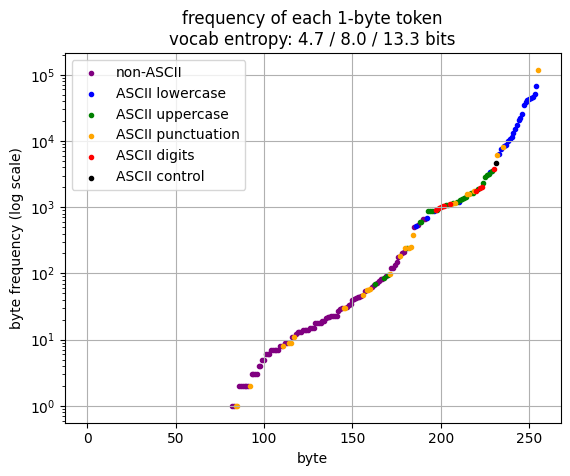

In [63]:
init_vocab = Counter({bytes([i]): FREQS_CACHE.get(bytes([i]), 0) for i in range(256)})

init_tokens_freqs = list(reversed(init_vocab.most_common()))
init_tokens, init_freqs = zip(*init_tokens_freqs)
init_freqs = np.array(init_freqs)
init_tokens = np.array(init_tokens)

x = torch.arange(len(init_freqs))

# ascii byte ranges
punct_idx = np.isin(init_tokens, ASCII_PUNCTUATION)
digit_idx = np.isin(init_tokens, ASCII_DIGITS)
lower_idx = np.isin(init_tokens, ASCII_LOWERCASE)
upper_idx = np.isin(init_tokens, ASCII_UPPERCASE)
cntrl_idx = np.isin(init_tokens, ASCII_CONTROL)
other_idx = np.isin(init_tokens, ASCII_OTHER)

# plot frequencies
plt.scatter(x[other_idx], init_freqs[other_idx], marker='.', color='purple', label='non-ASCII')
plt.scatter(x[lower_idx], init_freqs[lower_idx], marker='.', color='blue', label='ASCII lowercase')
plt.scatter(x[upper_idx], init_freqs[upper_idx], marker='.', color='green', label='ASCII uppercase')
plt.scatter(x[punct_idx], init_freqs[punct_idx], marker='.', color='orange', label='ASCII punctuation')
plt.scatter(x[digit_idx], init_freqs[digit_idx], marker='.', color='red', label='ASCII digits')
plt.scatter(x[cntrl_idx], init_freqs[cntrl_idx], marker='.', color='black', label='ASCII control')
plt.yscale('log')
plt.title(f'frequency of each 1-byte token\nvocab entropy: {entropy(init_freqs):.1f} / {np.log2(256):.1f} / {MAX_ENTROPY:.1f} bits')
plt.xlabel('byte')
plt.ylabel('byte frequency (log scale)')
#plt.xticks(list(range(0, 257, 32))) #, rotation=90, labels=xtick_labels)
plt.xmin = 0
plt.xmax = 256
plt.grid()
plt.legend()
#plt.savefig('1-byte-token-frequencies.png', dpi=300)
plt.show()
plt.close()

### frequency spread over time

generating data stream:   0%|          | 0/22 [00:00<?, ?frame/s]

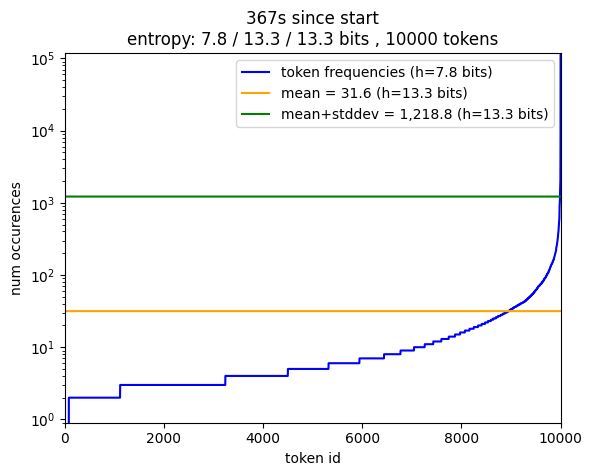

In [64]:
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
import matplotlib.animation as animation


class Animated(object):
    def __init__(self, x_time, y_freqs, frame_rate):
        self.x_time, self.y_freqs = x_time, y_freqs
        self.stream = self.data_stream()
        self.frame_rate = frame_rate
        self.ymin = 1
        self.ymax = max([int(f) for f in self.y_freqs[0]])
        self.t0 = x_time[0]

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=200, 
                                          save_count=len(self.x_time), blit=True) # init_func=self.update, 

    def data_stream(self):
        for t_raw, y_raw in tqdm(zip(self.x_time, self.y_freqs), total=len(self.x_time), desc="generating data stream", unit="frame", leave=True):
            #t = time.strftime('%Y-%m-%d @ %I:%M:%S %Z', time.gmtime(t_raw)) # + str(t_raw % 60)
            t = round(t_raw - self.t0)
            y = np.array(sorted(y_raw))
            x = np.arange(len(y))
            yield (t, x, y)

    def update(self, i=0):
        try:
            t, x, y = next(self.stream)
        except StopIteration:
            return []
        for line in self.ax.lines:
            line.remove()
        #print(f"{len(y)=:,}")

        ymean = y.mean()
        ystd = y.std()
        ideal_y = ymean * np.ones(len(y))

        log = True
        plots = [] 
        pl, = self.ax.plot(x, y, color='blue', label=f'token frequencies (h={entropy(y):.01f} bits)')
        plots.append(pl)
        pl, = self.ax.plot(x, ideal_y, color='orange', label=f'mean = {ymean:,.1f} (h={np.log2(len(y)):.1f} bits)')
        plots.append(pl)
        pl, = self.ax.plot(x, ideal_y + ystd, color='green', label=f'mean+stddev = {ymean+ystd:,.1f} (h={np.log2(len(y)):.1f} bits)')
        plots.append(pl)
        if ymean - ystd > 0:
            pl, = self.ax.plot(x, ideal_y - ystd, color='green', label=f'mean-stddev = {ymean-ystd:,.1f} (h={np.log2(len(y)):.1f} bits)')
            plots.append(pl)
        self.ax.set_title(f"{int(time.time()-x_time[0]):,}s since start\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {MAX_ENTROPY:.01f} bits , {len(y)} tokens")
        self.ax.set_ylabel('num occurences')
        self.ax.set_xlabel('token id')
        if log:
            self.ax.set_yscale('log')
        self.ax.set_xlim(0, MAX_VOCAB_SIZE)
        if log:
            self.ax.set_ylim(.9, max(y_freqs[0]))
        else:
            self.ax.set_ylim(0, max(y))
        self.ax.legend()
        return plots


framerate = 8
a = Animated(x_time, y_freqs, framerate)
#plt.show()
a.ani.save('test.mp4', fps=framerate, extra_args=['-vcodec', 'libx264'])
#a.ani.save('test.gif', fps=30)
